#### Importing Dependencies

In [129]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

#### Data Collection

In [130]:
big_mart_data = pd.read_csv('C:/Users/USER/Desktop/Datasets/train.csv')
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [131]:
# Checking the number of rows and columns
big_mart_data.shape

(8523, 12)

In [132]:
# Checking datatypes,missing and info about the big_mart_data 
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [133]:
big_mart_data.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

 ##### Categorical Features:
- Item_Identifier
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Out_Type

##### Handling Missing Values
- Using Mean for the 'Item_Weight'
- Using Mode for the 'Outlet_Size'

In [134]:
# mean value of 'Item_weight' 
item_weight_mean = big_mart_data['Item_Weight'].mean()
item_weight_mean

12.857645184135976

In [135]:
# filling the missing values in 'item_Weight' column with the mean
big_mart_data['Item_Weight'] = big_mart_data['Item_Weight'].fillna(item_weight_mean)


In [136]:
# Compute mode of Outlet_Size for each Outlet_Type
size_mode = big_mart_data.groupby('Outlet_Type')['Outlet_Size'].agg(lambda x: x.mode()[0])

# Apply mode-based imputation
big_mart_data['Outlet_Size'] = big_mart_data.apply(
    lambda row: size_mode[row['Outlet_Type']] if pd.isna(row['Outlet_Size']) else row['Outlet_Size'],
    axis=1
)


In [137]:
#Cleaning the Item Fat Content column
big_mart_data['Item_Fat_Content'] = big_mart_data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'
})


In [138]:
big_mart_data['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

In [139]:
missing_values = big_mart_data['Outlet_Size'].isnull()

In [140]:
print(missing_values)

0       False
1       False
2       False
3       False
4       False
        ...  
8518    False
8519    False
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [141]:
big_mart_data.loc[missing_values, 'Outlet_Size'] = big_mart_data.loc[missing_values, 'Outlet_Type'].apply(lambda x: outlet_size_mode)

In [142]:
# Check for missing values
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

#### Data Analysis

In [143]:
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


##### Numerical Features

In [144]:
sns.set()

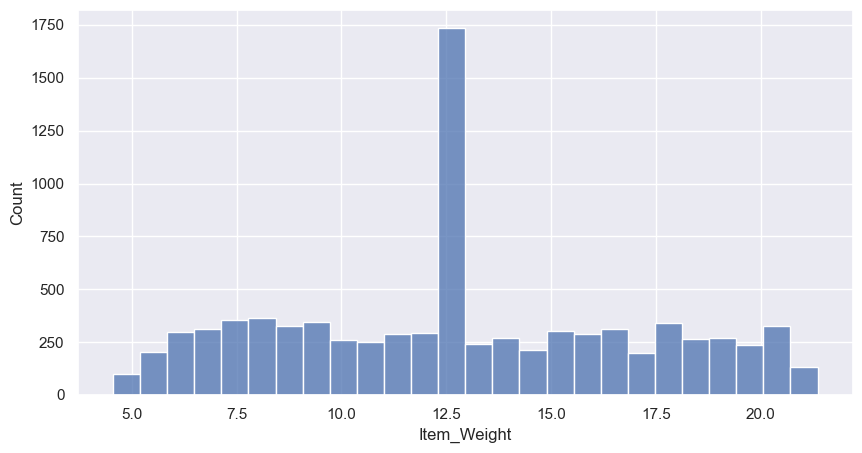

In [145]:
# Item_Weight distribution
plt.figure(figsize=(10,5))
sns.histplot(big_mart_data['Item_Weight'])
plt.show()

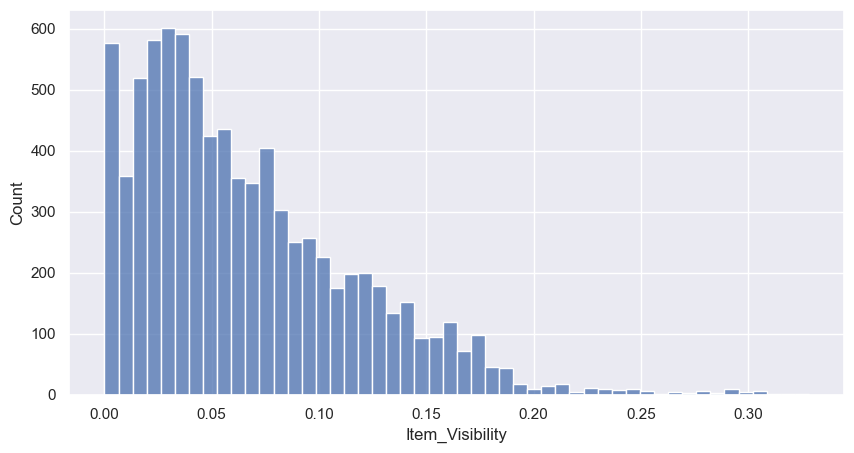

In [146]:
# Item_Visibily distribution
plt.figure(figsize=(10,5))
sns.histplot(big_mart_data['Item_Visibility'])
plt.show()

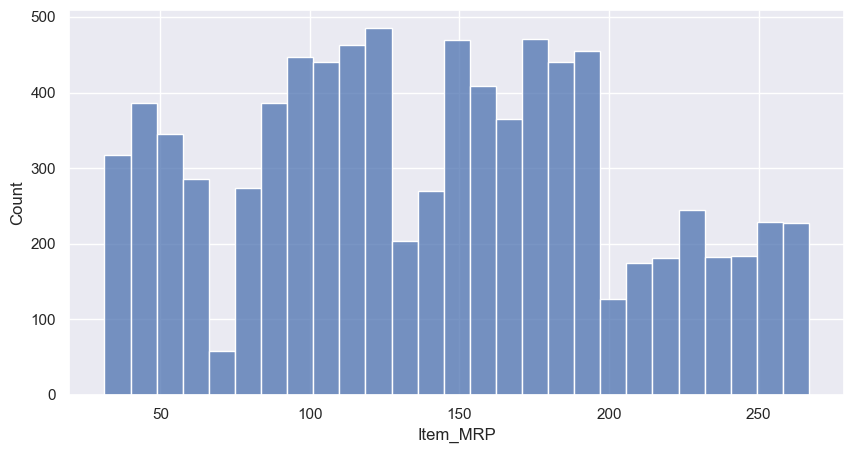

In [147]:
# Item_MRP distribution
plt.figure(figsize=(10,5))
sns.histplot(big_mart_data['Item_MRP'])
plt.show()

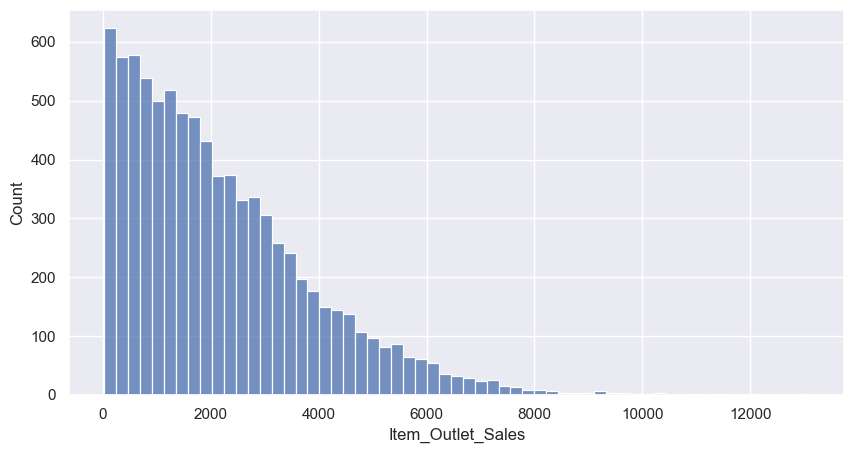

In [148]:
# Item_Outlet_Sales distribution
plt.figure(figsize=(10,5))
sns.histplot(big_mart_data['Item_Outlet_Sales'])
plt.show()

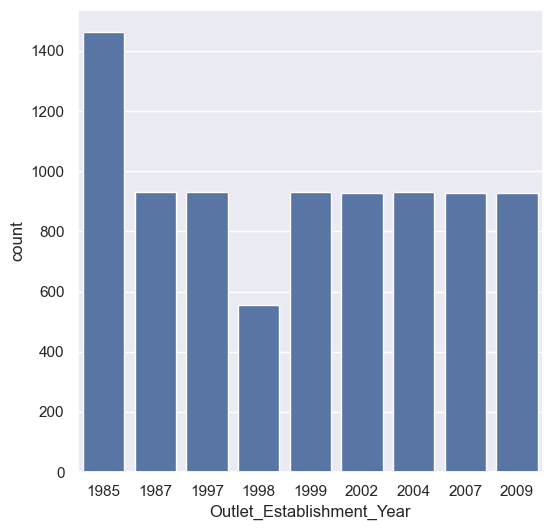

In [149]:
# Outlet_Establishment_Year distribution
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data)
plt.show()

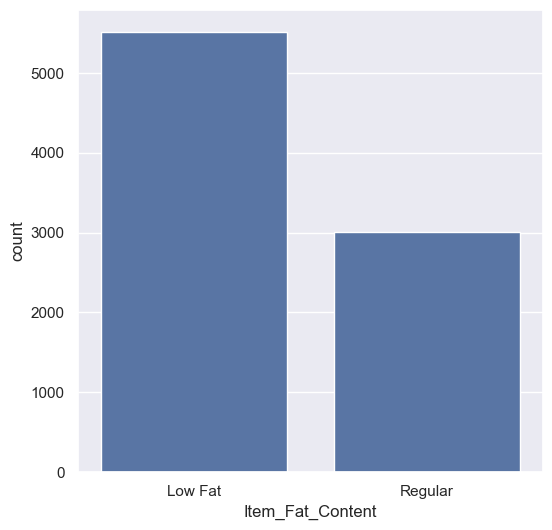

In [150]:
# Item fat content columns
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=big_mart_data)
plt.show()

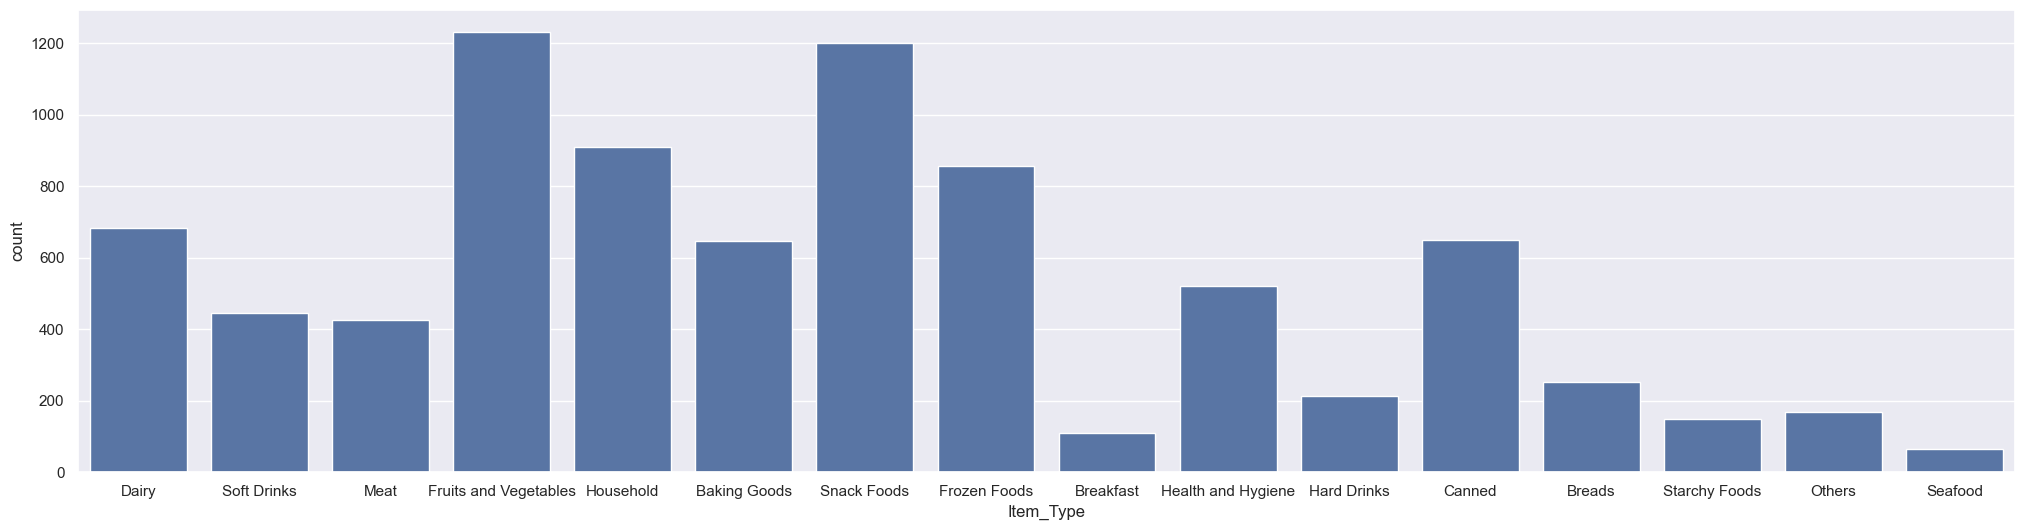

In [151]:
# Item type columns
plt.figure(figsize=(25,6))
sns.countplot(x='Item_Type', data=big_mart_data)
plt.show()

In [152]:
#big_mart_data['Outlet_Size'].head()
#print(big_mart_data['Outlet_Size'].dtype)
#print(big_mart_data['Outlet_Size'].unique())
# Check types inside the column
big_mart_data['Outlet_Size'].apply(type).value_counts()


Outlet_Size
<class 'str'>    8523
Name: count, dtype: int64

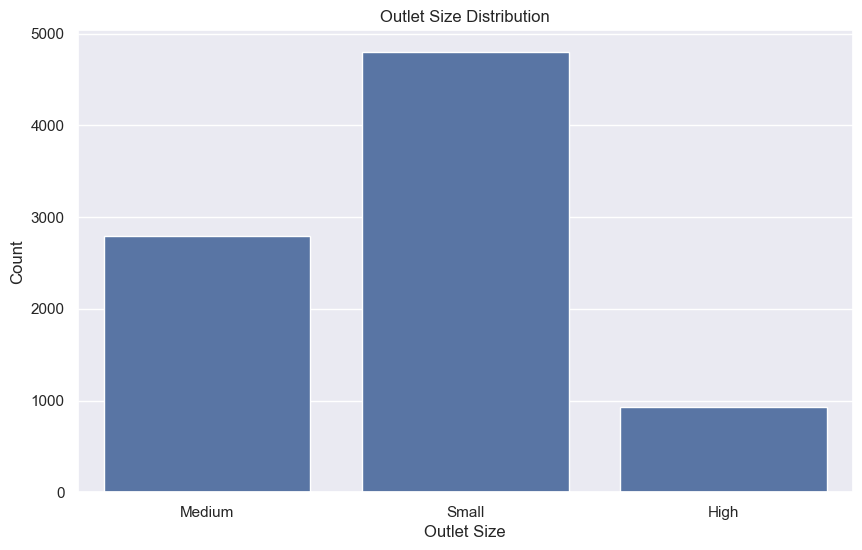

In [153]:
# Outlet size columns
plt.figure(figsize=(10,6))
#sns.countplot(x='Outlet_Size', data=big_mart_data)
sns.countplot(x='Outlet_Size', data=big_mart_data)  
plt.title("Outlet Size Distribution")
plt.xlabel("Outlet Size")
plt.ylabel("Count")
plt.show()

##### Label Encoding

In [154]:
encoder = LabelEncoder()

In [155]:
big_mart_data['Item_Identifier'] = encoder.fit_transform(big_mart_data['Item_Identifier'])
big_mart_data['Item_Fat_Content'] = encoder.fit_transform(big_mart_data['Item_Fat_Content'])
big_mart_data['Item_Type'] = encoder.fit_transform(big_mart_data['Item_Type'])
big_mart_data['Outlet_Identifier'] = encoder.fit_transform(big_mart_data['Outlet_Identifier'])
big_mart_data['Outlet_Size'] = encoder.fit_transform(big_mart_data['Outlet_Size'])
big_mart_data['Outlet_Location_Type'] = encoder.fit_transform(big_mart_data['Outlet_Location_Type'])
big_mart_data['Outlet_Type'] = encoder.fit_transform(big_mart_data['Outlet_Type'])


In [156]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


##### Splitting Features and Target

In [157]:
X = big_mart_data.drop(columns='Item_Outlet_Sales', axis=1)
Y = big_mart_data['Item_Outlet_Sales']

In [158]:
print(X)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0             4  249.8092                  9    

In [159]:
print(Y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64


##### Splitting the data into Training and Testing data

In [160]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=13)

In [161]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (6818, 11) (1705, 11)


##### Model Training with  **XGBRegressor**


In [162]:
regressor = XGBRegressor()

In [163]:
regressor.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

##### Evaluation

In [164]:
# Prediction on training dbig_mart_data
training_data_prediction = regressor.predict(X_train)

In [165]:
# R squared value
r2_train = metrics.r2_score(Y_train, training_data_prediction)

In [166]:
print('R Squared Value :',r2_train)

R Squared Value : 0.8739467557020891


In [167]:
# Prediction on test data 
test_data_prediction = regressor.predict(X_test)

In [168]:
# R squared value
r2_test = metrics.r2_score(Y_test, test_data_prediction)

In [170]:
print('R Squared Value :',r2_test)

R Squared Value : 0.5125926612805297
